# Exploratory Data Analysis

_Created by:_ Lewis Tunstall, August 2019

In this project we aim to build a predictive model of the Aare river temperature in Bern. This could be used to help companies like [Aare Guru](https://aare.guru/#bern) provide better forecasts that give the public the means to make data-driven decisions about when to go for a swim :) 

The focus of our analysis is temperature and flow rate measurements collected in Bern and Thun. The datasets below cover a time period of approximately 7 years, which may be sufficient to make a baseline model. 

In this notebook, we focus on a exploratory analysis to assess the quality of the data and identify possible gotchas in the time series.

### Summary of Results

* There are 3 datasets to explore: Aare measurements in Bern, Thun, and from OpenData. 
* The temperature and flow rate exhibit yearly seasonality in line with what one would expect across summer and winter.
* There are some suspicious values (e.g. negative temperatures and zero flow rates) that should be investigated further.
* No trend is observed in the data, as we would expect.

### TODO

* Explore the Thun and OpenData datasets.
* Consider joining the data into a single DataFrame for model building.
* Examine the outliers in temperature and flow rate.

## Load libraries

In [21]:
# reload modules before executing user code
%load_ext autoreload
# reload all modules every time before executing the Python code
%autoreload 2

In [105]:
# ml magic
from fastai.tabular import *

# dataviz
import seaborn as sns
sns.set(color_codes=True, rc={'figure.figsize':(12, 4)})
sns.set_palette(sns.color_palette('muted'))

# time wrangling
import matplotlib.dates as mdates
import datetime

## Load and explore the data
From the `_readme.txt` file we see that there are three types of dataset:

* **aare.csv:** Temperature, flow, and height data for Bern.
* **hydro_value_thun.csv:** Temperature, flow, and height data for Thun.
* **opendata.csv:** Various measurements from OpenData (need data dictionary!). For a possible data model, see [here](https://opendata.netcetera.com/smn/swagger#!/smn/getSmnRecord_get_2).

Let's load each dataset and take a peek at the first few values in each DataFrame:

In [50]:
DATA = Path('../data/')
!ls {DATA}

external  interim   processed raw


In [51]:
RAW = Path('../data/raw/')
!ls {RAW}

2017-03-29


In [52]:
RAW_2017 = RAW/'2017-03-29/'
!ls {RAW_2017}

Icon?                aare_as_csv.csv      opendata.csv.zip
_readme.txt          hydro_value_thun.csv
aare.csv             opendata.csv


---

**Note**

* The CSV files are _not_ comma-separated; instead they use `;` as the separator.
* `aare.csv` and `aare_as_csv.csv` are identical, modulo the choice of separator.

Since pandas can handle `;`-separated files with ease, I don't do any preprocessing at this step.

---

In [53]:
aare_df = pd.read_csv(RAW_2017/'aare.csv', sep=';'); aare_df.head()

date  temperature  flow  height
0  2009-07-08 18:50:00         17.4   NaN     NaN
1  2009-07-08 19:10:00         17.4   NaN     NaN
2  2009-07-08 19:20:00         17.4   NaN     NaN
3  2009-07-08 19:40:00         17.4   NaN     NaN
4  2009-07-08 19:50:00         17.4   NaN     NaN

In [54]:
open_df = pd.read_csv(RAW_2017/'opendata.csv', sep=';'); open_df.head()

datum_zeit station param  wert
0  2017-03-29 12:20:00     BER    tt  17.0
1  2017-03-29 12:20:00     BER    sd  10.0
2  2017-03-29 12:20:00     BER    rr   0.0
3  2017-03-29 12:20:00     BER    dd  11.0
4  2017-03-29 12:20:00     BER    ff   6.1

In [56]:
thun_df = pd.read_csv(RAW_2017/'hydro_value_thun.csv', sep=';'); thun_df.head()

mespar_id             datetime  value
0          2  2010-01-20 00:30:00   5.49
1          2  2010-01-20 00:40:00   5.49
2          2  2010-01-20 00:50:00   5.48
3          2  2010-01-20 01:10:00   5.46
4          2  2010-01-20 01:20:00   5.45

## Aare
We begin our analysis by focusing on the Aare dataset. From the data structure

In [65]:
aare_df.shape

(345551, 4)

we have 4 attributes, so let's get a quick description of each one's type and number of non-null values:

In [66]:
aare_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 345551 entries, 0 to 345550
Data columns (total 4 columns):
date           345551 non-null object
temperature    345551 non-null float64
flow           340696 non-null float64
height         340696 non-null float64
dtypes: float64(3), object(1)
memory usage: 10.5+ MB


Evidently the `flow` and `height` attributes are missing about 1.5% of their values, but this should be easy to handle with resampling and interpolation. Next, let's have a look to see if there are any duplicated timestamps:

In [67]:
num_duplicates = len(aare_df) - aare_df['date'].nunique()
print(f'Number of duplicate timestamps: {num_duplicates}')

Number of duplicate timestamps: 0


Good, the timestamps look OK so let's convert the `date` column from `object` data type (i.e. string) to `datetime64[ns]` so that we can slice, perform arithmetic etc in time:

In [69]:
# see https://docs.python.org/3/library/datetime.html#strftime-and-strptime-behavior for format options
aare_df['date'] = pd.to_datetime(aare_df['date'], format='%Y-%m-%d %H:%M:%S')

As a sanity check, let's look at the data types again:

In [70]:
aare_df.dtypes

date           datetime64[ns]
temperature           float64
flow                  float64
height                float64
dtype: object

Now that the `date` column has the correct data type, let's set it as the DataFrame's index and sort from earliest to latest:

In [71]:
aare_df.set_index('date', inplace=True)
aare_df.sort_index(inplace=True)

One of the useful feature of pandas `DatetimeIndex` objects is that we can easily extract the individual date/time components from them. Let's create three more columns with the year, month, and day of the week:

In [72]:
aare_df['year'] = aare_df.index.year
aare_df['month'] = aare_df.index.month
aare_df['weekday'] = aare_df.index.weekday_name

In [73]:
# sanity check with a random sample
aare_df.sample(n=5)

temperature    flow  height  year  month   weekday
date                                                                   
2014-11-18 17:40:00        10.87  115.06  502.15  2014     11   Tuesday
2012-12-22 00:10:00         6.70  103.68  502.05  2012     12  Saturday
2011-04-11 16:00:00        11.00  124.35  502.17  2011      4    Monday
2010-06-12 16:30:00        12.50  269.62  503.04  2010      6  Saturday
2015-01-03 01:30:00         6.35   51.28  501.59  2015      1  Saturday

Finally, let's check the range of our time series:

In [74]:
print(f'Start timestamp: {aare_df.index.min()}')
print(f'End timestamp: {aare_df.index.max()}')

Start timestamp: 2009-07-08 18:50:00
End timestamp: 2017-03-29 13:50:00


We have approximately 7 years of data - not bad!

### Times series visualisation
When the index of a DataFrame is of `DatetimeIndex` type, we can make plots by simply selecting the column and applying the `plot()` method, e.g. let's look at the temperature values:

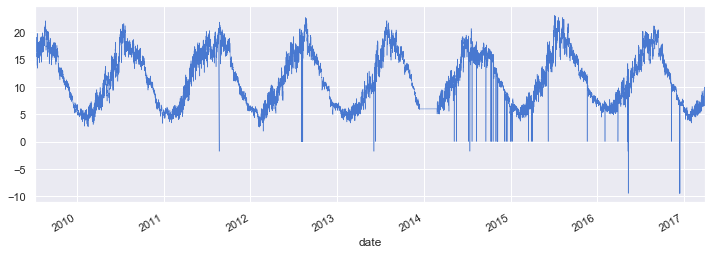

In [75]:
aare_df['temperature'].plot(linewidth=0.5);

As is common with line plots, when there are too many data points the resulting plot can be a bit hard to read. One alternative is to plot the data as dots instead of points; let's do that also for the flow and height data:

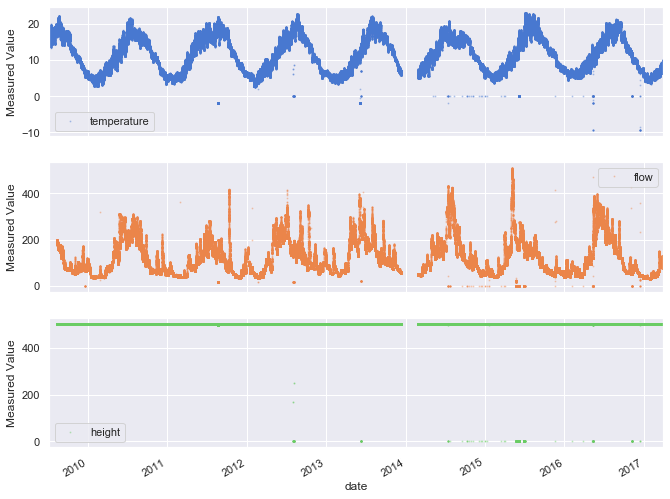

In [82]:
# select columns to plot
cols_plot = ['temperature', 'flow', 'height']
# create subplots
axes = aare_df[cols_plot].plot(marker='.', ms=2, alpha=0.3, linestyle='None', figsize=(11, 9), subplots=True)
# loop over subplots and add y label
for ax in axes:
    ax.set_ylabel('Measured Value')

We can already see some interesting patterns emerge:

* Water temperature is highest (lowest) in summer (winter), which is unsurprising given the seasonal effects of the weather.
* The flow rate is highest (lowests) in summer (winter), which is again not surprising since the summer months are also the wettest (see [here](http://www.bern.climatemps.com/precipitation.php)).
* The river height is largely constant across the whole time range. This might be obscured by the handful of zero values and warrants further investigation.
* There appears to be a hole in the data around the start of 2014 - find out why!

We also see that the `temperature` and `flow` time series exhibit _seasonality_, where the time series oscillates between high and low values on a yearly scale.

### Seasonality
Next let's take a closer look at seasonality and group the data by month to visualise the distributions:

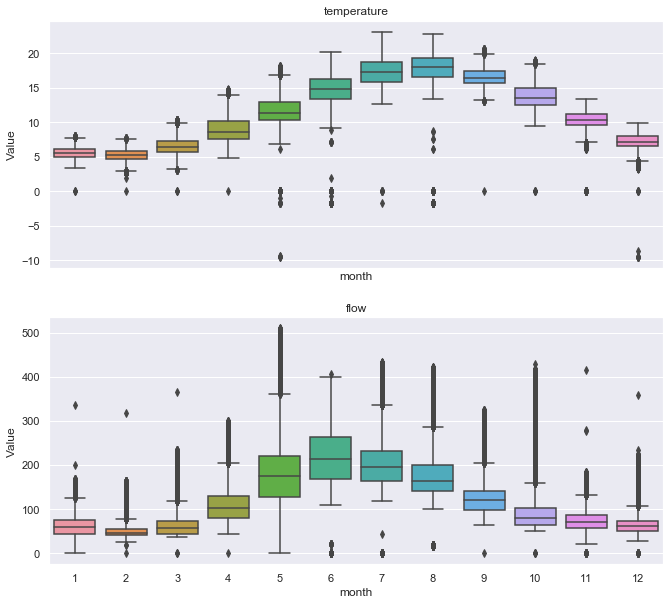

In [93]:
# setup plotting env
fig, axes = plt.subplots(2, 1, figsize=(11, 10), sharex=True)

# loop over columns to plot and assign to each row in subplots
for name, ax in zip(['temperature', 'flow'], axes):
    sns.boxplot(x='month', y=name, data=aare_df, ax=ax)
    ax.set_ylabel('Value')
    ax.set_title(name)

These plots confirm the seasonality we saw in the time series plots above but give additional information:

* Temperature and flow rate exhibit yearly seasonality, but flow rate has many more outliers.
* There are several sub-zero temperature values that seem suspicious (I doubt the Aare has ever frozen!). Similarly there are several zero values for the flow rate. These are presumably measurement errors and should be deleted / corrected before building any sort of predictive model.

### Resampling
We focus on downsampling and use the `resample()` method which splits the `DatetimeIndex` into bins and aggregates the data per bin. We can then apply methods like `mean()`, `sum()` etc to calculate metrics of interest.

For example, let's resample the time series to daily frequency:

In [96]:
data_cols = ['temperature', 'flow', 'height']
aare_daily_df = aare_df[data_cols].resample('D').mean()
aare_daily_df.head()

temperature  flow  height
date                                 
2009-07-08    17.133333   NaN     NaN
2009-07-09    16.066265   NaN     NaN
2009-07-10    15.508861   NaN     NaN
2009-07-11    14.922378   NaN     NaN
2009-07-12    16.288732   NaN     NaN

### Rolling windows
Rolling windows are an operation that is similar to downsampling, with the difference that the windows overlap where aggregation is performed. Let's use this to calculate a 7-day rolling mean of our daily data (we use `center=True` to label each window at its midpoint):

In [98]:
# compute the centered 7-day rolling mean
aare_7d_df = aare_daily_df[data_cols].rolling(7, center=True).mean()
aare_7d_df.head()

temperature  flow  height
date                                 
2009-07-08          NaN   NaN     NaN
2009-07-09          NaN   NaN     NaN
2009-07-10          NaN   NaN     NaN
2009-07-11    16.522952   NaN     NaN
2009-07-12    16.564897   NaN     NaN

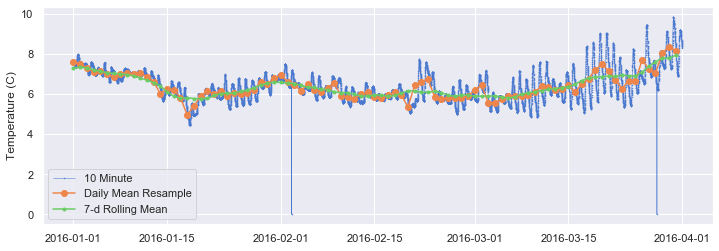

In [101]:
# start and end of the date range to extract
start, end = '2016-01', '2016-03'
# Plot 10 minute, daily, and 7-day rolling mean time series together
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(aare_df.loc[start:end, 'temperature'],
marker='.', ms=1, linestyle='-', linewidth=0.5, label='10 Minute')
ax.plot(aare_daily_df.loc[start:end, 'temperature'],
marker='o', markersize=6, linestyle='-', label='Daily Mean Resample')
ax.plot(aare_7d_df.loc[start:end, 'temperature'],
marker='.', linestyle='-', label='7-d Rolling Mean')
ax.set_ylabel('Temperature (C)')
ax.legend();

### Trends

In [115]:
aare_365d_df = aare_daily_df[data_cols].rolling(window=365, center=True, min_periods=350).mean()

In [120]:
def plot_trend(column_name):

    # plot daily, 7-day rolling mean, and 365-day rolling mean time series
    fig, ax = plt.subplots(figsize=(12,4))

    ax.plot(aare_df[column_name], marker='.', markersize=1, color='0.6',
    linestyle='None', label='10 Minute')

    ax.plot(aare_7d_df[column_name], linewidth=2, label='7-d Rolling Mean')

    ax.plot(aare_365d_df[column_name], color='0.2', linewidth=3,
    label='Trend (365-d Rolling Mean)')

    # set x-ticks to yearly interval and add legend and labels
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.legend()
    ax.set_xlabel('Year')
    ax.set_ylabel('Temperature (C)')
    ax.set_title('Trends in Temperature');

/Users/lewtun/git/aareguru-forecast/env/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/lewtun/git/aareguru-forecast/env/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


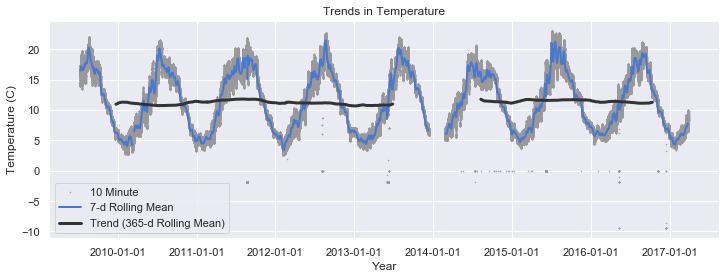

In [121]:
plot_trend('temperature')

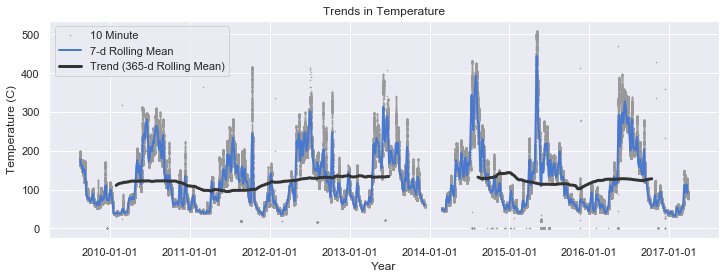

In [122]:
plot_trend('flow')

Thus we conclude that the trend in both `temperature` and `flow` is essentially flat. Again not so surprisingly given the fact that these values are dictated by the climate / weather and local changes from e.g. climate change are unlikely to be visible on these time scales.